In [37]:
import os
import time
import glob
import pickle
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import MeanSquaredError

In [50]:
IM_SIZE = (720, 1280)
LOAD_MODEL = False

In [51]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=IM_SIZE, antialias = True)
    img = img / 255.0
    return img

In [52]:
!python -V
print(tf.__version__)

Python 3.10.12
2.12.0


In [53]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Input Image', 'Real Image', 'Output Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [54]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [55]:
def data_path(orig_img_path, hazy_img_path):
    train_img = []
    val_img = []
    test_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[: int(0.8*n)]
    val_keys = orig_img[int(0.8*n): int(0.9*n)]
    test_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
    for key in test_keys:
        split_dict[key] = 'test'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + 'c' + img_name[1:]
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        elif (split_dict[orig_path] == 'val'):
            val_img.append([img, orig_path])
        else:
            test_img.append([img, orig_path])
            
    return train_img, val_img, test_img

In [56]:
def dataloader(train_data, val_data, test_data, batch_size):
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    test_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in test_data]).map(lambda x: load_image(x))
    test_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in test_data]).map(lambda x: load_image(x))
    test = tf.data.Dataset.zip((test_data_haze, test_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, val, test

In [57]:
def dehaze_net():
    inputs = tf.keras.Input(shape=[720, 1280, 3])

    conv1 = Conv2D(input_shape=(720, 1280, 3), filters=3, kernel_size=1, strides=1, padding='same', use_bias=True,
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02), kernel_regularizer=tf.keras.regularizers.l2(1e-2))(inputs)

    conv2 = Conv2D(filters=3, kernel_size=3, strides=1, padding='same', use_bias=True,
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02), kernel_regularizer=tf.keras.regularizers.l2(1e-2))(conv1)

    concat1 = tf.concat([conv1, conv2], axis=-1)

    conv3 = Conv2D(filters=3, kernel_size=5, strides=1, padding='same', use_bias=True,
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02), kernel_regularizer=tf.keras.regularizers.l2(1e-2))(concat1)

    concat2 = tf.concat([conv2, conv3], axis=-1)

    conv4 = Conv2D(filters=3, kernel_size=7, strides=1, padding='same', use_bias=True,
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02), kernel_regularizer=tf.keras.regularizers.l2(1e-2))(concat2)

    concat3 = tf.concat([conv1, conv2, conv3, conv4], axis=-1)

    conv5 = Conv2D(filters=3, kernel_size=3, strides=1, padding='same', use_bias=True,
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02), kernel_regularizer=tf.keras.regularizers.l2(1e-2))(concat3)

    K = conv5

    output = ReLU(max_value=1.0)(tf.math.multiply(K, inputs) - K + 1.0)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())

    return model

In [58]:
batch_size = 1

train_data, val_data, test_data = data_path(orig_img_path='/kaggle/input/dataset-of-dehazing/clear', hazy_img_path='/kaggle/input/dataset-of-dehazing/haze')
train, val, test = dataloader(train_data, val_data, test_data, batch_size)

In [59]:
if LOAD_MODEL:
    model = tf.keras.models.load_model('/kaggle/input/aod-net-fog-model-v2/aod_net_fog_v2.h5')
else:
    model = dehaze_net()
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError())
    history = model.fit(train, validation_data=val, epochs=100, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 720, 1280, 3  12          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 720, 1280, 3  84          ['conv2d[0][0]']                 
                                )                                                             

In [60]:
# filename = '/kaggle/working/aod_net_fog_v2.sav'
# pickle.dump(model, open(filename, 'wb'))

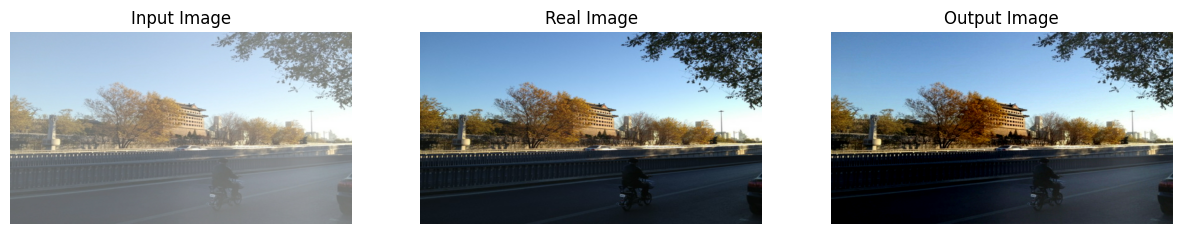

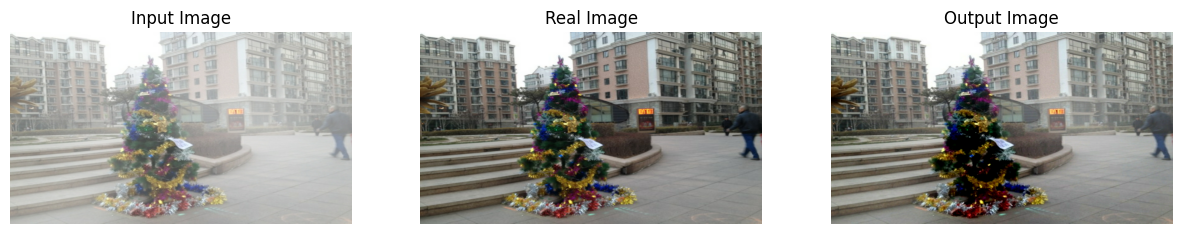

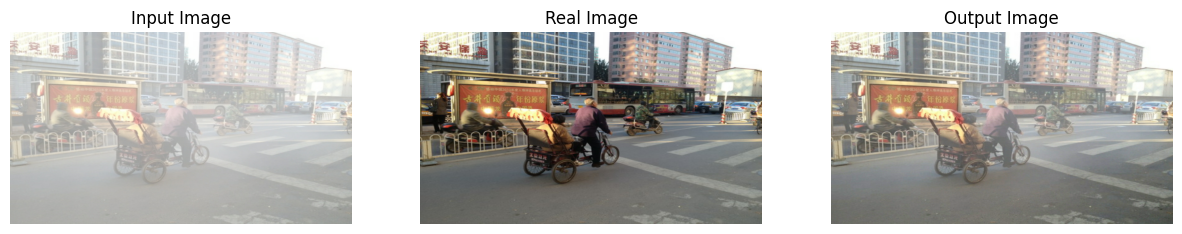

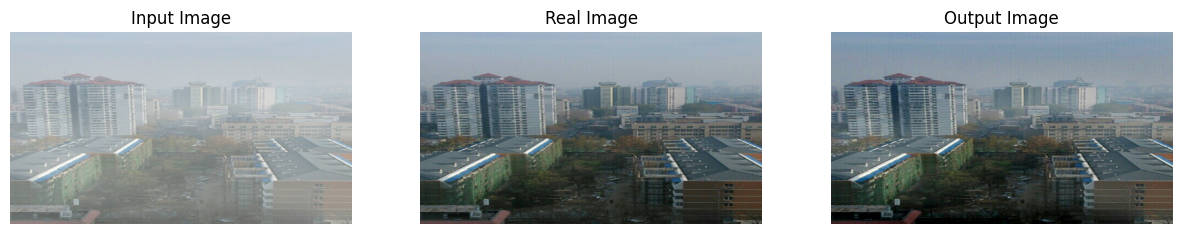

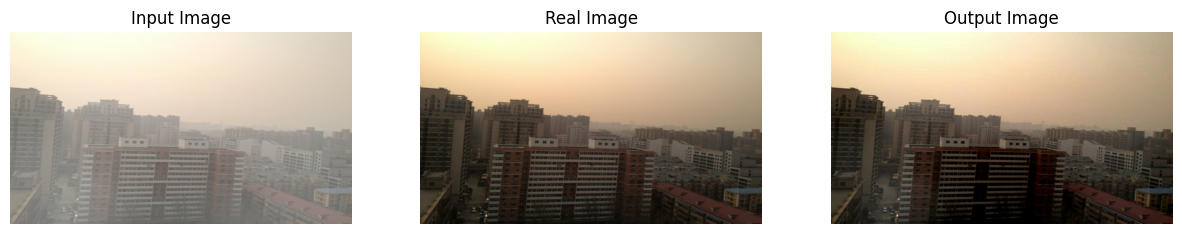

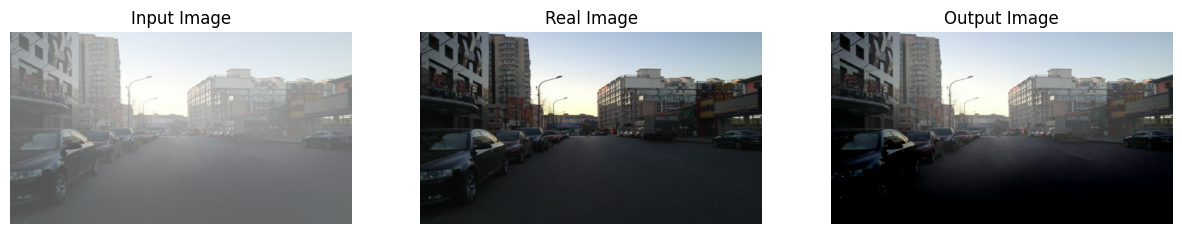

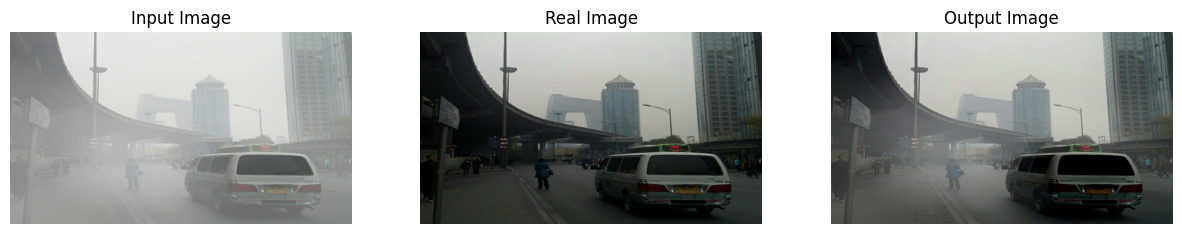

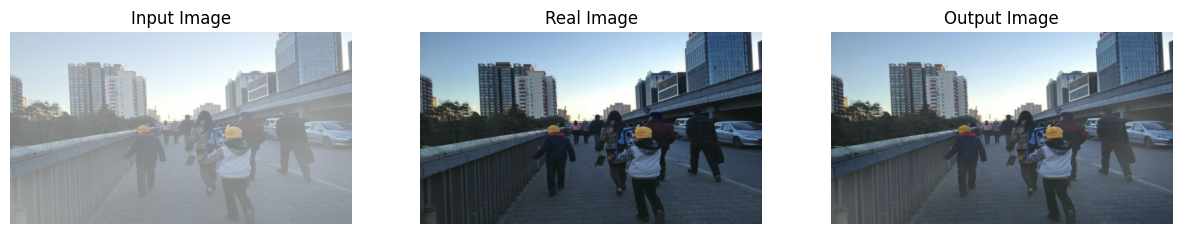

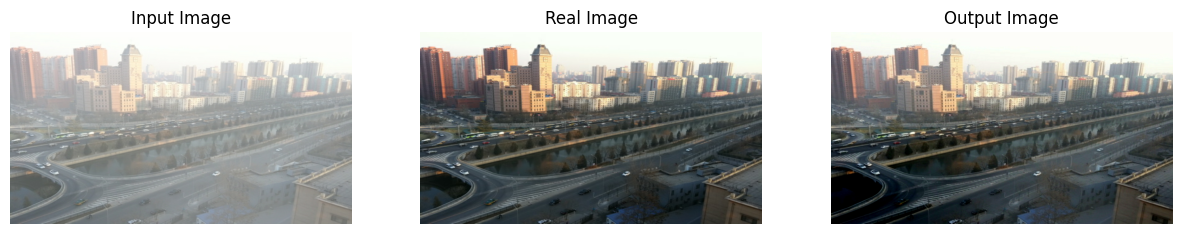

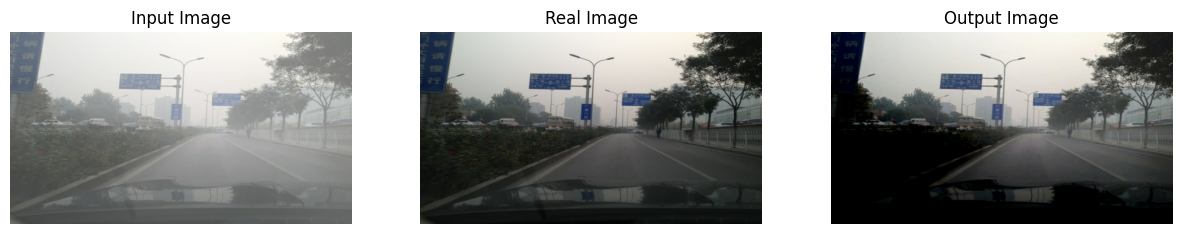

In [61]:
for i, (hz, og) in enumerate(test):
    if i == 10:
        break
    display_img(model, hz, og)

In [62]:
import math
max_pixel_value = 255
val_MSE = history.history['val_loss'][-1]
PSNR = 10 * math.log10((max_pixel_value^2) / val_MSE)
PSNR

43.79164865705788

In [63]:
if not LOAD_MODEL:
    model.save('/kaggle/working/aod_net_fog_v2.h5')

In [64]:
loaded_model = tf.keras.models.load_model('/kaggle/working/aod_net_fog_v2.h5')

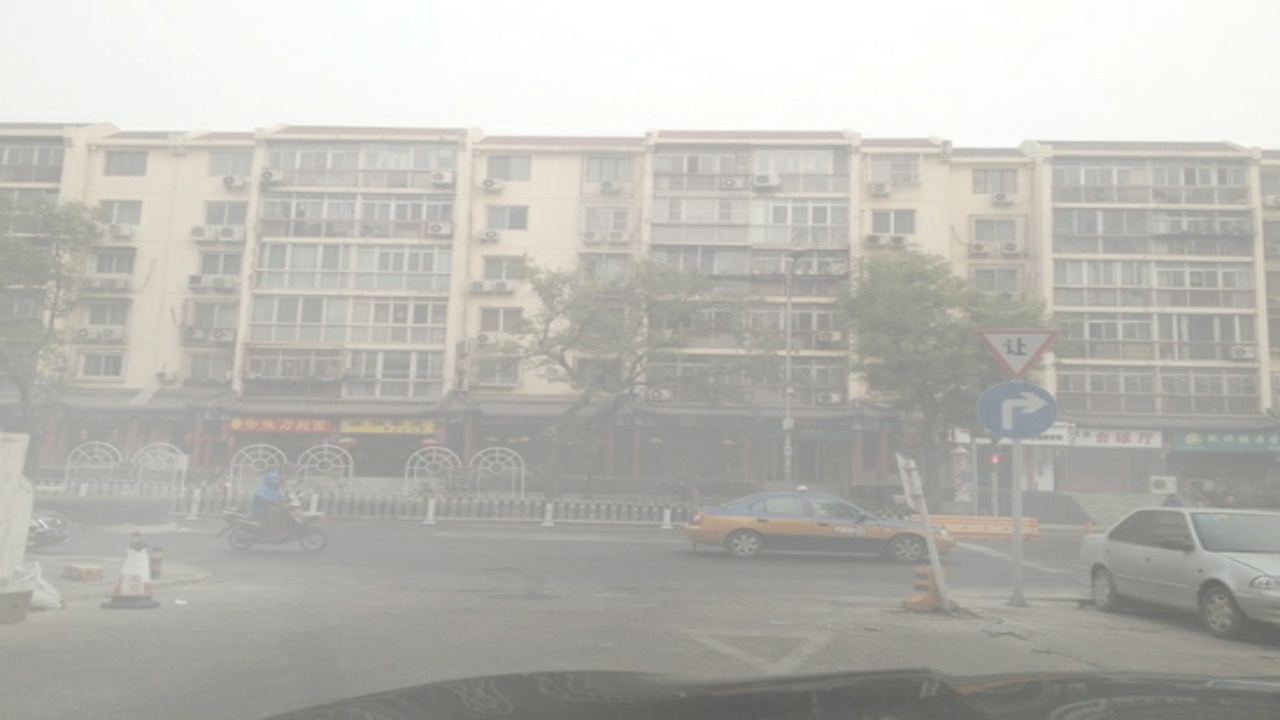

In [65]:
test_input_image = '/kaggle/input/dataset-of-dehazing/haze/h482.jpg'
in_img = load_image(test_input_image)
tensor_to_image(in_img)

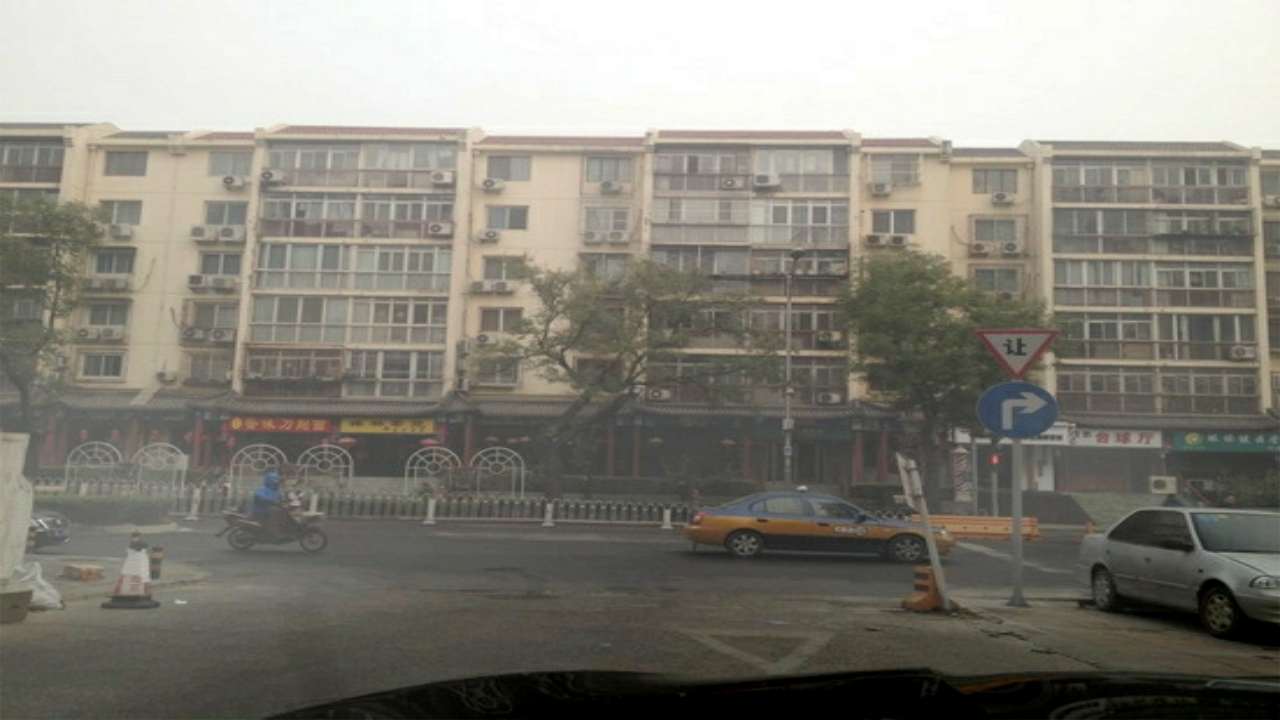

In [66]:
img = tf.expand_dims(in_img, 0)
pred = loaded_model(img)
tensor_to_image(pred)